In [111]:
from pathlib import Path
from collections import namedtuple

#import numpy as np
#import matplotlib.pyplot as plt
#from pyometiff import OMETIFFWriter
import webknossos as wk

#import dask.array as da

#import pandas as pd
#from skimage.measure import label, regionprops_table
#from skimage.color import label2rgb

from webknossos import BoundingBox
#import matplotlib.pyplot as plt

from webknossos_utils import Pixel_size, Annotation
#import napari

import io

In [112]:
use_napari = False

In [113]:

# this comes from the WEBKNOSSOS website, under the user settings
AUTH_TOKEN = "1mng65J7d-5IVFmfJoF4rw" # from gisela
AUTH_TOKEN = "S-QRDIegZYX0IM1lXmyiJg"
WK_TIMEOUT="3600" # in seconds
ORG_ID = "83d574429f8bc523" # gisela's webknossos

#sample1   = Annotation("6644c04d0100004a01fa11af", "deprecated","60_2_5R")
#sample2    = Annotation("664316880100008a049e890e", "deprecated","60_2_3L")
id_1 = "6644c04d0100004a01fa11af"
id_2 = "664316880100008a049e890e"
id_3 = "664606440100005102550210"
id_4 = "664316880100008a049e890e"

In [114]:
# the dataset url comes from the WEBKNOSSOS website, open the image of interest from the dashboard and check
# I removed the view information

ANNOTATION_ID = id_4

with wk.webknossos_context(token=AUTH_TOKEN):
    annotations = wk.Annotation.open_as_remote_dataset(annotation_id_or_url=ANNOTATION_ID)
    lbl_layers = annotations.get_segmentation_layers()

    DATASET_NAME = annotations._properties.id['name']
    ds = wk.Dataset.open_remote(dataset_name_or_url=DATASET_NAME, organization_id=ORG_ID)
    img_layer = ds.get_color_layers()
    assert len(img_layer) == 1, "more than an image, this is unexpected for this project"
    img_layer = img_layer[0]

    #dataset = wk.Dataset.open_remote(DATASET_URL)
    #img_data = dataset.get_color_layer().get_finest_mag().read()

c:\Users\rafaelCCI\mambaforge\envs\wk-env\lib\site-packages\webknossos\annotation\annotation.py:462: UserWarning: [INFO] Omitting the volume layer annotation data for layers ['Mitochondria', 'Dystrophic_myelin', 'Myelin', 'Axon'], as their location is not referenced in the NML.
  warnings.warn(


In [115]:
voxel_size = ds.voxel_size
print(img_layer)
print(f'image size in pixels {img_layer.bounding_box.size.to_np()}')
print(f'voxel size in nm: {ds.voxel_size}')

mag_list = list(img_layer.mags.keys())
print(mag_list)

Layer('60_2_3L', dtype_per_channel=uint8, num_channels=1)
image size in pixels [30404 20950     1]
voxel size in nm: (5.0, 5.0, 70.0)
[Mag(1), Mag(2-2-1), Mag(4-4-1), Mag(8-8-1), Mag(16-16-1), Mag(32-32-1), Mag(64-64-1), Mag(128-128-1), Mag(256-256-1), Mag(512-512-1)]


In [116]:
import numpy as np
import dask.array as da
#import matplotlib.pyplot as plt
from pyometiff import OMETIFFWriter

In [117]:
MAG = mag_list[3]
pSize = Pixel_size(voxel_size[0] * MAG.x, voxel_size[1] * MAG.y, voxel_size[2] * MAG.z, MAG=MAG, unit="nm")
print(pSize)
with wk.webknossos_context(token=AUTH_TOKEN, timeout=WK_TIMEOUT):
    img_data = img_layer.get_mag(pSize.MAG).read()
print(img_data.shape)
img_dask = da.from_array(np.swapaxes(img_data,-1,-3), chunks=(1,1,512,512))
img_dask

output_fpath = Path.cwd().joinpath("gisela_ds_" + img_layer.name + "_mag_" + str(pSize.MAG) + ".ome.tiff")
print(output_fpath)

assert pSize.unit == "nm", "should be nm for this to work"
metadata_dict = {
    "PhysicalSizeX" : str(pSize.x/1000),
    "PhysicalSizeXUnit" : "µm",
    "PhysicalSizeY" : str(pSize.y/1000),
    "PhysicalSizeYUnit" : "µm",
    "PhysicalSizeZ" : str(pSize.z/1000),
    "PhysicalSizeZUnit" : "µm",
    "Channels" : {
        "SEM" : {
            "Name" : "BSD",
            "SamplesPerPixel": 1,
        },
    }
}

# a string describing the dimension ordering
dimension_order = "CZYX"

writer = OMETIFFWriter(
    fpath=output_fpath,
    dimension_order=dimension_order,
    array=img_dask,
    metadata=metadata_dict,
    explicit_tiffdata=False)

writer.write()

Pixel_size(x=40.0, y=40.0, z=70.0, MAG=Mag(8-8-1), unit='nm')
(1, 3801, 2619, 1)
e:\PROJECTS\CCI\Image_Processing_Projects\Gisela\gisela_ds_60_2_3L_mag_8-8-1.ome.tiff


In [118]:
if use_napari:
    print("use napari")
    #viewer.add_image(data=img_dask, channel_axis=0, name=img_layer.name)

In [119]:
for lbl in lbl_layers:
    print(lbl)
    print(lbl.name)
    print(lbl.bounding_box.size.to_np())

Layer('Mitochondria', dtype_per_channel=uint32, num_channels=1)
Mitochondria
[30404 20950     1]
Layer('Dystrophic_myelin', dtype_per_channel=uint32, num_channels=1)
Dystrophic_myelin
[30404 20950     1]
Layer('Myelin', dtype_per_channel=uint32, num_channels=1)
Myelin
[30404 20950     1]
Layer('Axon', dtype_per_channel=uint32, num_channels=1)
Axon
[30404 20950     1]


In [120]:
for i, lbl in enumerate(lbl_layers):
    if lbl.name == "Myelin":
        myelin_idx = i
    elif lbl.name == "Axon":
        axon_idx = i
    elif lbl.name == "Mitochondria":
        mito_idx = i
    elif lbl.name == "Dystrophic_myelin":
        dystrophic_idx = i

print(myelin_idx)
print(axon_idx)

2
3


In [121]:
with wk.webknossos_context(token=AUTH_TOKEN):
    lbl_data = lbl_layers[myelin_idx].get_mag(pSize.MAG).read()
unique_lbls = np.unique(lbl_data)
print(unique_lbls)


if np.max(unique_lbls) < 512:
    lbl_data = lbl_data.astype(np.uint8)

lbl_dask = da.from_array(np.swapaxes(lbl_data,-1,-3), chunks=(1,5,512,512))
lbl_dask

output_fpath = Path.cwd().joinpath("gisela_ds_" + img_layer.name + "_mag_" + str(pSize.MAG) + "_lbl_Myelin.ome.tiff")
print(output_fpath)

assert pSize.unit == "nm", "should be nm for this to work"
metadata_dict = {
    "PhysicalSizeX" : str(pSize.x/1000),
    "PhysicalSizeXUnit" : "µm",
    "PhysicalSizeY" : str(pSize.y/1000),
    "PhysicalSizeYUnit" : "µm",
    "PhysicalSizeZ" : str(pSize.z/1000),
    "PhysicalSizeZUnit" : "µm",
    "Channels" : {
        "SEM" : {
            "Name" : "Myelin",
            "SamplesPerPixel": 1,
        },
    }
}

# a string describing the dimension ordering
dimension_order = "CZYX"

writer = OMETIFFWriter(
    fpath=output_fpath,
    dimension_order=dimension_order,
    array=lbl_dask,
    metadata=metadata_dict,
    explicit_tiffdata=False)

writer.write()

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200]
e:\PROJECTS\CCI\Image_Processing_Projects\Gisela\gisela_ds_60_2_3L_mag_8-8-1_lbl_Myelin.ome.tiff


In [122]:
if use_napari:
    print("use napari")
    #viewer.add_labels(lbl_dask, name="myelin")

In [123]:
from skimage.measure import label, regionprops_table
import pandas as pd
from skimage.color import label2rgb

In [124]:
properties = ['label', 'bbox']
reg_table = regionprops_table(label_image=lbl_dask[0,0,:,:],
                          properties=properties)
reg_table = pd.DataFrame(reg_table)
reg_table.sample(5)

,label,bbox-0,bbox-1,bbox-2,bbox-3
163,164,1137,1616,1162,1634
126,127,1184,1421,1211,1449
11,12,1497,1779,1517,1795
197,198,889,1928,916,1950
26,27,1522,1904,1559,1933


In [125]:
from webknossos_utils import skibbox2wkbbox
import matplotlib.pyplot as plt

(1, 640, 472, 1)


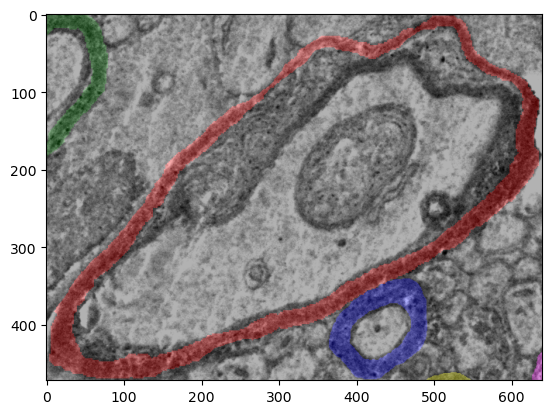

In [126]:
bbox = skibbox2wkbbox(reg_table.iloc[0].to_dict(), pSize)
bbox

with wk.webknossos_context(token=AUTH_TOKEN, timeout=WK_TIMEOUT):
    img_data = img_layer.get_finest_mag().read(absolute_offset=bbox.topleft, size=bbox.size)
    #img_data = img_layer.get_mag(pSize.MAG).read(absolute_offset=bbox.topleft, size=bbox.size)
    lbl_data = lbl_layers[myelin_idx].get_finest_mag().read(absolute_offset=bbox.topleft, size=bbox.size)
    #lbl_data = lbl_layers[annotation_idx].get_mag(pSize.MAG).read(absolute_offset=bbox.topleft, size=bbox.size)
print(img_data.shape)

color1 = label2rgb(lbl_data.squeeze().T, image=img_data.squeeze().T, bg_label=0)
plt.imshow(color1)


In [127]:
from time import sleep
from IPython.display import clear_output
from skimage.morphology import convex_hull_image
from skimage.measure import find_contours
from scipy import ndimage

import myelin_morphometrics as morpho
import warnings

In [128]:
from scipy.ndimage import center_of_mass

def bbox_from_BWimg(BW):
    # convex hull calculation including smoothing to avoid pixelation effects
    chull_img = convex_hull_image(BW)
    chull_contour = find_contours(chull_img)
    assert len(chull_contour)==1, "we only expect one contour"

    convex_hull = morpho.smoothBoundary(chull_contour[0])
    min_box_corners, min_box_edges, rot_mat = morpho.minBoundingBox(convex_hull, 'width')

    min_box_corners = min_box_corners - np.mean(min_box_corners, axis=0)
    #   move the box to the same reference as the inpurt convex hull
    c_mass = center_of_mass(chull_img, labels=None, index=None)
    min_box_corners = min_box_corners + c_mass


    return min_box_corners, min_box_edges, rot_mat

def get_box_with_rotation(bw_img, rot_mat):
    chull_img = convex_hull_image(bw_img)
    chull_contour = find_contours(chull_img)
    assert len(chull_contour)==1, "we only expect one contour"
    convex_hull = morpho.smoothBoundary(chull_contour[0])
    r_hull = morpho.rotate_points(convex_hull, rot_mat)
    box_dim = morpho.bbox_dimenssions(r_hull)

    #print(box_dim)

    min_bbox_points = np.array([
        [0, 0],
        [box_dim[0], 0],
        [box_dim[0], box_dim[1]],
        [0, box_dim[1]]
    ])

    #   rotate the box
    min_bbox_corners = morpho.rotate_points(min_bbox_points, rot_mat.T)
    #   move the box to 0,0
    min_bbox_corners = min_bbox_corners - np.mean(min_bbox_corners, axis=0)
    #   move the box to the same reference as the inpurt convex hull
    c_mass = center_of_mass(chull_img, labels=None, index=None)
    min_bbox_corners = min_bbox_corners + c_mass #((np.max(convex_hull, axis=0)-np.min(convex_hull, axis=0))/2)+np.min(convex_hull, axis=0)

    return min_bbox_corners, box_dim

In [129]:
out_folder = Path("./output/"+DATASET_NAME)
out_folder

# Check if the folder exists
if not out_folder.exists():
    # If the folder doesn't exist, create it
    out_folder.mkdir()
    print(f"Folder '{out_folder}' created successfully.")
else:
    print(f"Folder '{out_folder}' already exists.")

Folder 'output\60_2_3L' created successfully.


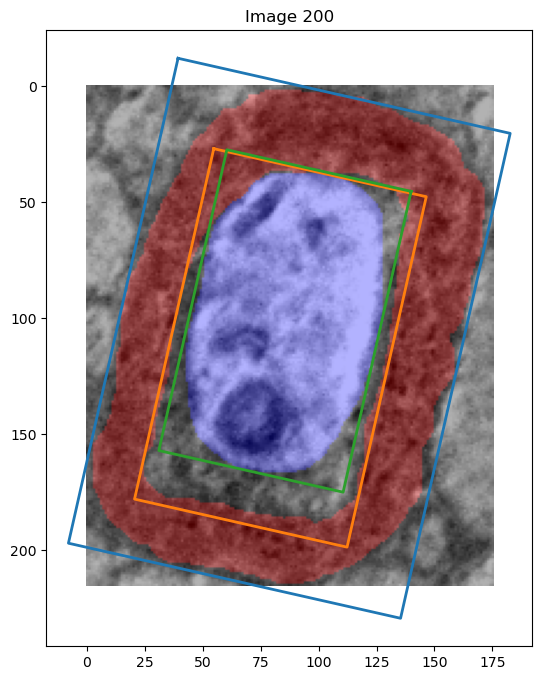

done for index: 200


In [130]:
from skimage.morphology import remove_small_objects, isotropic_erosion
total_table = []
pad_size = 5
with wk.webknossos_context(token=AUTH_TOKEN, timeout=WK_TIMEOUT):
    for index, row in reg_table.iterrows():
        print(row)
        obj_idx = row['label']

        bbox = skibbox2wkbbox(row.to_dict(), pSize)
        img_data = img_layer.get_finest_mag().read(absolute_offset=bbox.topleft, size=bbox.size)

        myelin_lbl = lbl_layers[myelin_idx].get_finest_mag().read(absolute_offset=bbox.topleft, size=bbox.size).squeeze()
        axon_lbl   = lbl_layers[axon_idx].get_finest_mag().read(absolute_offset=bbox.topleft, size=bbox.size).squeeze()
        mito_lbl   = lbl_layers[mito_idx].get_finest_mag().read(absolute_offset=bbox.topleft, size=bbox.size).squeeze()
        dyst_lbl   = lbl_layers[dystrophic_idx].get_finest_mag().read(absolute_offset=bbox.topleft, size=bbox.size).squeeze()


        # get area of the iamge identified as myelin, this is my main ROI which defines behaviour of all others.
        myelin_bw = morpho.get_BW_from_lbl(myelin_lbl, obj_idx)
        # clean myelin label map, in case other neurons are close by
        myelin_lbl[np.logical_not(myelin_bw)] = 0

        properties = ['label', 'area','eccentricity','solidity','intensity_mean',
                      'axis_minor_length','axis_major_length','feret_diameter_max']
        obj_table = regionprops_table(label_image=myelin_lbl,
                                      intensity_image=img_data.squeeze(),
                                      properties=properties)
        obj_table = pd.DataFrame(obj_table)
        obj_table.rename(columns={'area': 'myelin_area', 
                          'eccentricity': 'myelin_eccentricity',
                          'solidity': 'myelin_solidity',
                          'intensity_mean': 'myelin_intensity_mean',
                          'axis_minor_length': 'myelin_axis_minor_length',
                          'axis_major_length': 'myelin_axis_major_length',
                          'feret_diameter_max': 'myelin_feret_diameter_max'}, inplace=True)

        assert len(obj_table.axes[0]) == 1, "we expected to have a single object"
        
        # Create the padded myelin_bw image to avoid edge effects in the contours
        myelin_bw_fill = ndimage.binary_fill_holes(myelin_bw)
        # create the "axon area", this is the internal area of the myelin region
        auto_axon_region = np.logical_xor(myelin_bw_fill,myelin_bw)
        if np.sum(auto_axon_region)<100:
            warnings.warn("The axon was most probably not closed.")
            myelin_bw_fill = convex_hull_image(myelin_bw_fill)
            auto_axon_region = np.logical_xor(myelin_bw_fill,myelin_bw)
            auto_axon_region = isotropic_erosion(auto_axon_region, 3)
            auto_axon_region = remove_small_objects(auto_axon_region, min_size=500)
            assert np.sum(auto_axon_region)>500, "unexpected problems with the auto axon region"



        myelin_filled_area = np.sum(myelin_bw_fill)
        obj_table['myelin_filled_area'] =myelin_filled_area


        myelin_bw_pad = np.pad(myelin_bw_fill, ((pad_size, pad_size), (pad_size, pad_size),), mode='constant', constant_values=0)
        # convex hull calculation including smoothing to avoid pixelation effects
        myelin_min_box_corners, myelin_min_box_edges, rot_mat = bbox_from_BWimg(myelin_bw_pad)
        # using the bbox as feret calculator and AR
        obj_table['myelin_feret_max'] = np.max(myelin_min_box_edges)
        obj_table['myelin_feret_min'] = np.min(myelin_min_box_edges)
        obj_table['myelin_AR'] = np.max(myelin_min_box_edges)/np.min(myelin_min_box_edges)
        # calculating myelin median width
        obj_table['myelin_width'] = morpho.get_width(myelin_bw)


        auto_axon_area = np.sum(auto_axon_region)
        obj_table['myelin_hole_area'] =auto_axon_area

        max_axon_bbox, max_axon_size = get_box_with_rotation(auto_axon_region, rot_mat.T)

        myelin_width_min_feret = np.min(myelin_min_box_edges)-np.min(max_axon_size)
        myelin_width_max_feret = np.max(myelin_min_box_edges)-np.max(max_axon_size)
        obj_table['myelin_width_min_feret_direction'] = myelin_width_min_feret/2
        obj_table['myelin_width_max_feret_direction'] = myelin_width_max_feret/2

        # cleaning axon label map
        axon_bw = axon_lbl>0
        axon_bw = np.logical_and(myelin_bw_fill, axon_bw)
        user_def_axon = np.any(axon_bw)

        if not(user_def_axon):
            print('no user defined axon, we will create one based on the myelin')
            axon_bw = auto_axon_region 
        assert np.any(axon_bw), "The axon label map is empty: does not contain any True values"
        
        # I do not expect holes in the axon image
        axon_bw = ndimage.binary_fill_holes(axon_bw)
        axon_bw_pad = np.pad(axon_bw, ((pad_size, pad_size), (pad_size, pad_size),), mode='constant', constant_values=0)

        # convex hull calculation including smoothing to avoid pixelation effects
        axon_min_box_corners, axon_min_box_edges, _ = bbox_from_BWimg(axon_bw_pad)

        # using the bbox as feret calculator and AR
        obj_table['axon_area'] = np.sum(axon_bw_pad)
        obj_table['axon_feret_max'] = np.max(axon_min_box_edges)
        obj_table['axon_feret_min'] = np.min(axon_min_box_edges)
        obj_table['axon_AR'] = np.max(axon_min_box_edges)/np.min(axon_min_box_edges)

        #check the mito labels
        mito_bw = mito_lbl>0
        mito_bw = np.logical_and(myelin_bw_fill, mito_bw)
        user_def_mito = np.any(mito_bw)


        if not(user_def_mito):
            print('no mito in the neuron')
            mito_number = 0
            mito_total_area = 0
        else:
            mito_lbl = label(mito_bw)
            mito_number = np.max(mito_lbl)
            mito_total_area = np.sum(mito_bw)

        obj_table['mito_total_area'] = mito_total_area
        obj_table['mito_number'] = mito_number


        # cleaning the distrophic label:
        # cleaning axon label map
        dyst_bw = dyst_lbl>0
        dyst_bw = np.logical_and(myelin_bw_fill, dyst_bw)
        is_dystrophic = np.any(dyst_bw)
        obj_table['is_dystrophic'] = is_dystrophic
        # for later plot
        axon_lbl[np.logical_not(axon_bw)] = 0
        axon_lbl[axon_bw] = obj_table['label'] + 1

        mito_lbl[np.logical_not(mito_bw)] = 0
        mito_lbl[mito_bw] = obj_table['label'] + 2

        dyst_lbl[dyst_lbl>0] = obj_table['label'] + 3

        color = label2rgb(myelin_lbl.T + axon_lbl.T + mito_lbl.T + dyst_lbl.T, image=img_data.squeeze().T, bg_label=0)

        # Plot the image
        clear_output(wait=True)
        # Create a figure and axis for plotting
        fig, ax = plt.subplots(figsize=(8, 8))

        ax.imshow(color)
        tmp = np.vstack((myelin_min_box_corners, myelin_min_box_corners[0,:]))
        ax.plot(tmp[:, 0]-pad_size, tmp[:, 1]-pad_size, linewidth=2)

        tmp = np.vstack((max_axon_bbox, max_axon_bbox[0,:]))
        ax.plot(tmp[:, 0], tmp[:, 1], linewidth=2)

        tmp = np.vstack((axon_min_box_corners, axon_min_box_corners[0,:]))
        ax.plot(tmp[:, 0]-pad_size, tmp[:, 1]-pad_size, linewidth=2)



        ax.set_title(f'Image {obj_idx}')

        fig.canvas.draw()
        # Display the plot (necessary for Jupyter Notebooks)
        png_name = f'myelin_label_{obj_idx}.png'
        plt.savefig(out_folder.joinpath(png_name))
        plt.show()

        if isinstance(total_table, pd.DataFrame):
            # then I concatenate
            total_table = pd.concat([total_table, obj_table], axis=0)
        else:
            total_table = obj_table

        print(f"done for index: {obj_idx}")

        #if index>=1:
        #    break

In [131]:
# Write the DataFrame to an Excel file
xlsx_name = DATASET_NAME + "_morphometrics.xlsx"
total_table.to_excel(out_folder.joinpath(xlsx_name), index=False, engine='xlsxwriter')

In [132]:
total_table

,label,myelin_area,myelin_eccentricity,myelin_solidity,myelin_intensity_mean,myelin_axis_minor_length,myelin_axis_major_length,myelin_feret_diameter_max,myelin_filled_area,myelin_feret_max,...,myelin_hole_area,myelin_width_min_feret_direction,myelin_width_max_feret_direction,axon_area,axon_feret_max,axon_feret_min,axon_AR,mito_total_area,mito_number,is_dystrophic
0,1,32184.0,0.885893,0.187882,91.021160,415.218331,895.081762,716.297424,163947,715.903432,...,131763,16.267550,27.711558,88162,601.669976,224.069594,2.685192,16813,1,True
0,2,7739.0,0.673521,0.643951,93.324848,122.360898,165.538717,146.290806,11776,142.086560,...,4037,21.988181,29.197277,4037,83.692006,59.811876,1.399254,0,0,False
0,3,4411.0,0.403689,0.361468,95.985718,151.047656,165.098100,136.124943,12011,126.695858,...,7600,12.727922,12.374369,3700,81.427546,58.344976,1.395622,0,0,False
0,4,9878.0,0.693371,0.448613,97.067524,174.296082,241.882786,204.687567,21498,204.106927,...,11620,21.489882,25.514344,7640,128.022884,77.581901,1.650164,0,0,False
0,5,5866.0,0.607937,0.555072,96.720593,122.247404,153.966872,134.063418,10375,133.828797,...,4509,19.463114,20.161382,4509,93.987979,61.607570,1.525591,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,196,8576.0,0.795868,0.368575,100.257229,168.394989,278.122738,229.270583,22855,228.699873,...,14279,15.064300,19.236530,9540,158.939104,82.325514,1.930618,0,0,False
0,197,9471.0,0.740076,0.464196,87.718720,161.286704,239.823259,198.080792,19841,197.092492,...,10370,18.216761,23.354443,5994,121.240974,66.159847,1.832546,0,0,False
0,198,10537.0,0.633515,0.398284,90.522160,202.000200,261.073129,214.105114,25950,206.237989,...,15413,17.233742,21.520753,15413,167.418315,125.525057,1.333744,0,0,False
0,199,13471.0,0.581835,0.454963,92.922500,213.961622,263.076024,219.544984,28746,213.460183,...,15275,20.899148,30.824016,11697,141.884306,105.862089,1.340275,0,0,False
